In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
import plotly.express as px
import plotly.graph_objects as go
from reorder import reorder_coords

In [36]:
# Read in 3D data
file_path = 'data/3D/wing_init/output/wing_000_slices.dat'  # Replace with your file path
with open(file_path, 'r') as f:
    s = f.readlines()

# Read in 3D data
start = []
nzones=0

nnods = []
nelms = []
zcoords = []

for i, line in enumerate(s):
    if line.strip().startswith('DATAPACKING=POINT'):
        start.append(i+1)
        nnod = int(s[i-1].split('=')[1].split()[0])
        nelm = int(s[i-1].split('=')[2].split()[0])
        nnods.append(nnod)
        nelms.append(nelm)
        nzones += 1

        # Get zcoordinates
        z = float(s[i-2].split('=')[-1].split()[0][:-1])
        zcoords.append(z)

    else:
        continue

data = []
for i, (ind, nnod, nelm) in enumerate(zip(start,nnods, nelms)):
    slice_dat = np.genfromtxt(s[ind:ind+nnod], dtype=float)
    connectivity  = np.genfromtxt(s[ind+nnod:ind+nnod+nelm], dtype=float)
    df_tmp = pd.DataFrame(slice_dat[:,[0,1,2,6,7,8,9]], columns=['CoordinateX', 'CoordinateY', 'CoordinateZ', 'VX', 'VY', 'VZ', 'CP'])

    df_conn = pd.DataFrame(connectivity, columns=['NodeC1', 'NodeC2'])

    df_slice = pd.Series(i*np.ones(slice_dat.shape[0], dtype='int'), name='Slice_ID')
    
    result = pd.concat([df_tmp, df_conn, df_slice], axis=1)
    df_tmp = result.reindex(df_tmp.index)

    index_list = list(reorder_coords(df_tmp, return_indices=True))
    df_tmp = df_tmp.loc[index_list]

    data.append(df_tmp.values[:,[0,1,2,3,4,5,6,9]])


stacked_data = np.vstack(data)

df = pd.DataFrame(stacked_data, columns=['CoordinateX', 'CoordinateY', 'CoordinateZ', 'VX', 'VY', 'VZ', 'CP', 'SliceID'])

zmax = max(zcoords)

In [37]:
# Read in 2D data
file_path = 'data/2D/case_372/fc_000_slices.dat'  # Replace with your file path
with open(file_path, 'r') as f:
    s = f.readlines()

# Extract 2D surface data

for i, line in enumerate(s):
    if line.strip().startswith('DATAPACKING=POINT'):
        nnod = int(s[i-1].split('=')[1].split()[0].split(',')[0])
        nelm = int(s[i-1].split('=')[2].split()[0].split(',')[0])

        d2_dat = s[i+1:i+1+nnod]
        
        d2_dat = np.genfromtxt(d2_dat, dtype=float)

        break

d2_df = pd.DataFrame(d2_dat[:,[0,1,2,6,7,8,9]], columns=['CoordinateX', 'CoordinateY', 'CoordinateZ', 'VX', 'VY', 'VZ', 'CP'])

zmax = max(zcoords)

connectivity = np.genfromtxt(s[i+1+nnod:], dtype=float)
df_conn = pd.DataFrame(connectivity, columns=['NodeC1', 'NodeC2'])

result = pd.concat([d2_df, df_conn], axis=1)
d2_df = result.reindex(d2_df.index)

index_list = list(reorder_coords(d2_df, return_indices=True))
d2_df = d2_df.loc[index_list]

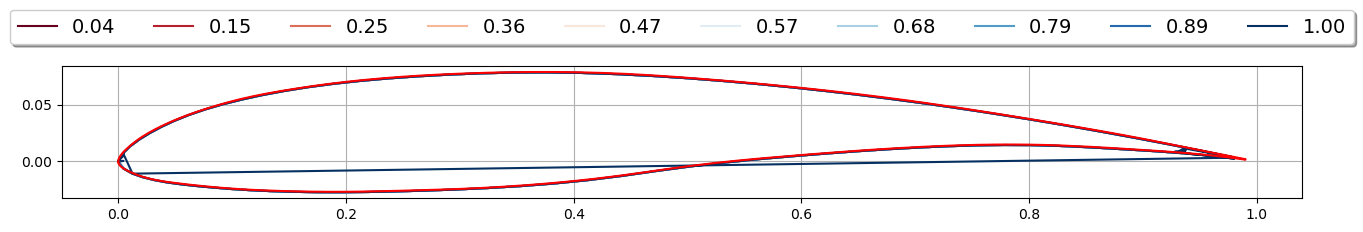

In [38]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot()

# Calculate the color for each dataset
cmap = plt.get_cmap('RdBu')
colors = [cmap(i) for i in np.linspace(0, 1, len(data))]

for color, dat, z in zip(colors, data, zcoords):
    x = dat[:,0]
    y = dat[:,1]
    vx = dat[:,3]
    vy = dat[:,4]
    p = dat[:,6]
    
    ax.plot(x,y, color=color, label=f'{z/max(zcoords):.2f}')

ax.plot(d2_df['CoordinateX'].values, d2_df['CoordinateY'].values, c='r')

ax.grid()
ax.set_aspect('equal')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5),
              ncol=min(len(data), len(data)), fancybox=True, shadow=True, fontsize=14)

# Set the azimuth and elevation angles
plt.savefig('coords.png')
plt.show()

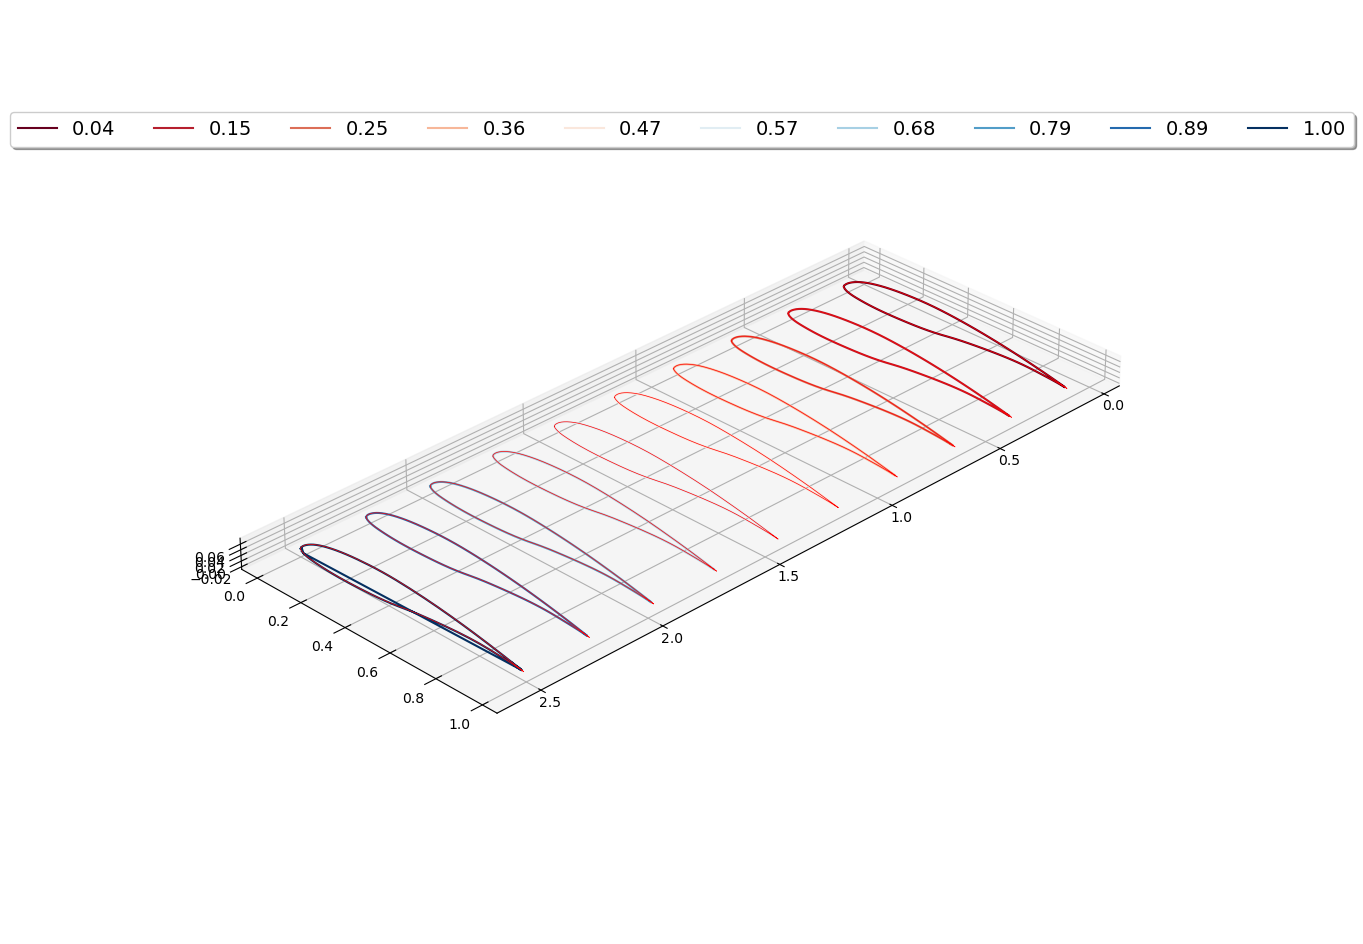

In [39]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')

# Calculate the color for each dataset
cmap = plt.get_cmap('RdBu')
colors = [cmap(i) for i in np.linspace(0, 1, len(data))]

for color, dat, z in zip(colors, data, zcoords):
    x = dat[:,0]
    y = dat[:,1]
    vx = dat[:,3]
    vy = dat[:,4]
    p = dat[:,6]
    
    ax.plot(z*np.ones(x.shape), x,y, color=color, label=f'{z/max(zcoords):.2f}')

    ax.plot(z*np.ones(d2_df['CoordinateX'].values.shape), d2_df['CoordinateX'].values, d2_df['CoordinateY'].values, c='r', linewidth=.5)

ax.grid()
ax.set_aspect('equal')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.9),
              ncol=min(len(data), len(data)), fancybox=True, shadow=True, fontsize=14)

# Set the azimuth and elevation angles
ax.view_init(azim=45, elev=30)
plt.savefig('coords.png')
plt.show()

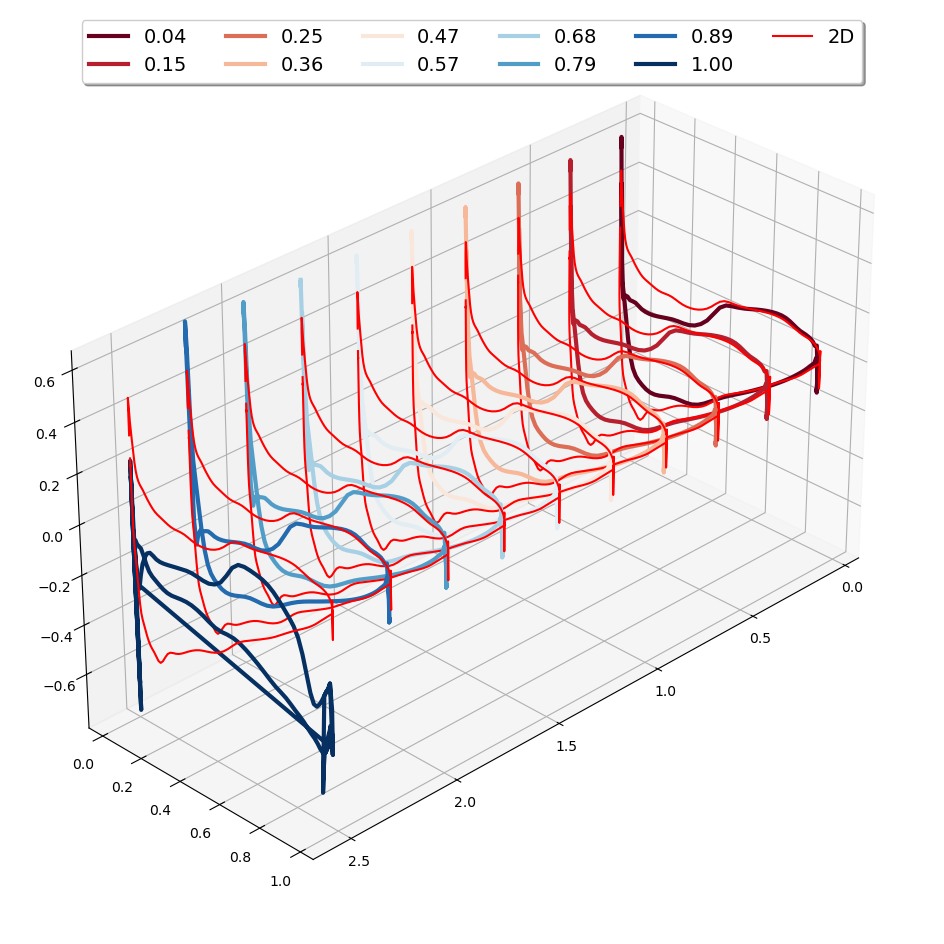

In [40]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')

# Calculate the color for each dataset
cmap = plt.get_cmap('RdBu')
colors = [cmap(i) for i in np.linspace(0, 1, len(data))]

for color, dat, z in zip(colors, data, zcoords):
    x = dat[:,0]
    y = dat[:,1]
    vx = dat[:,3]
    vy = dat[:,4]
    p = dat[:,6]
    
    ax.plot(z*np.ones(x.shape), x, p/(p.max()-p.min()), color=color, label=f'{z/max(zcoords):.2f}', linewidth=3)

    if z==zmax:
        break
    ax.plot(z*np.ones(d2_df['CoordinateX'].values.shape), d2_df['CoordinateX'].values, d2_df['CP'].values/(d2_df['CP'].values.max() - d2_df['CP'].values.min()), color='red')

ax.plot(z*np.ones(d2_df['CoordinateX'].values.shape), d2_df['CoordinateX'].values, d2_df['CP'].values/(d2_df['CP'].values.max() - d2_df['CP'].values.min()), color='red', label='2D')


ax.grid()

ax.set_aspect('equal')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
              ncol=min(len(data)//2+1, len(data)), fancybox=True, shadow=True, fontsize=14)

# Set the azimuth and elevation angles
ax.view_init(azim=45, elev=30)
plt.savefig('pressure.png')
plt.show()

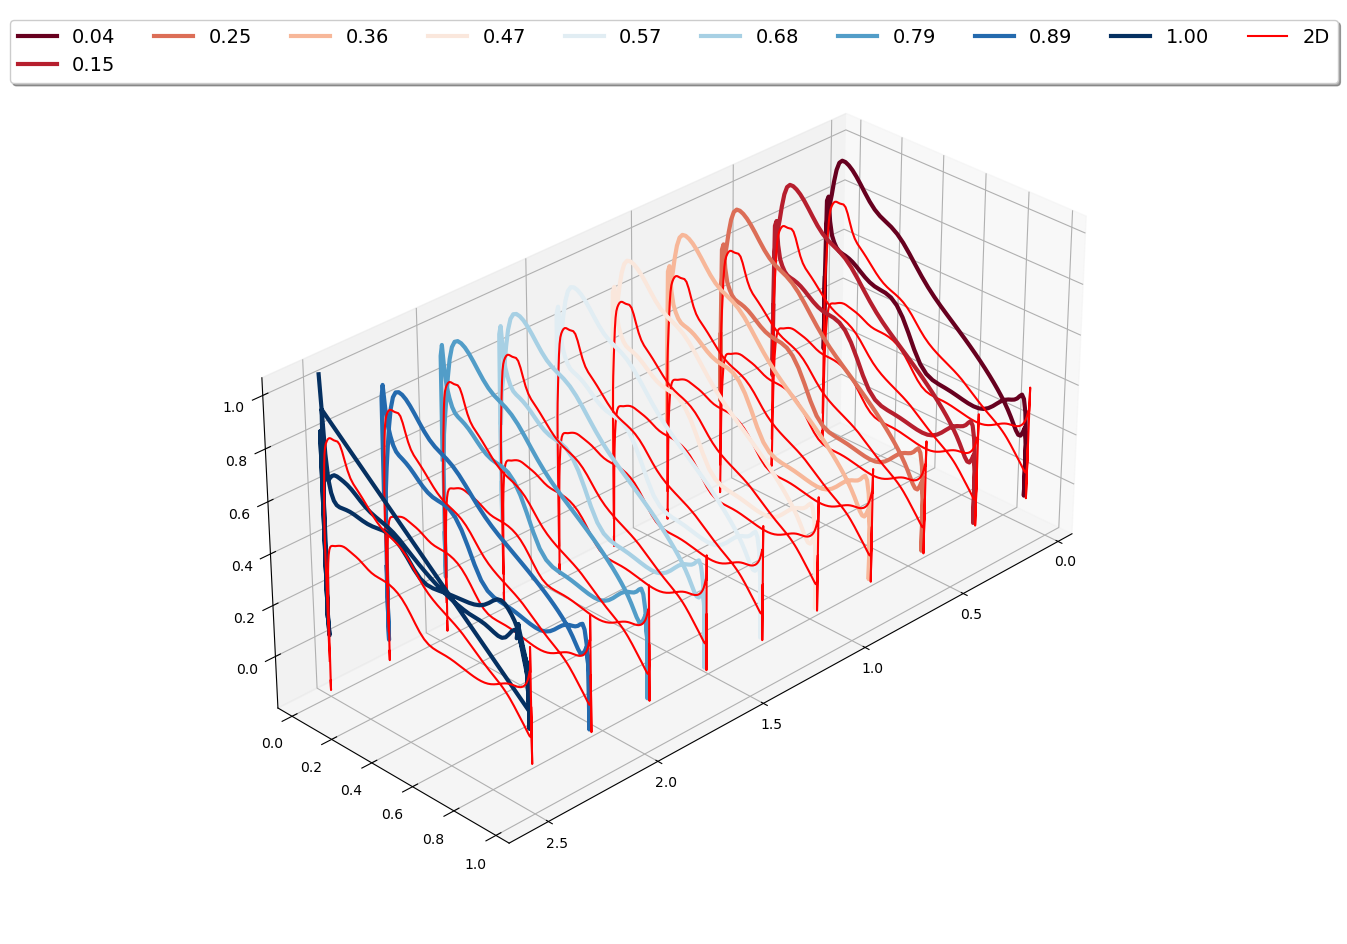

In [41]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')

# Calculate the color for each dataset
cmap = plt.get_cmap('RdBu')
colors = [cmap(i) for i in np.linspace(0, 1, len(data))]

for color, dat, z in zip(colors, data, zcoords):
    x = dat[:,0]
    y = dat[:,1]
    vx = dat[:,3]
    vy = dat[:,4]
    p = dat[:,6]
    
    ax.plot(z*np.ones(x.shape), x, vx/(vx.max()-vx.min()), color=color, label=f'{z/max(zcoords):.2f}', linewidth=3)

    if z==zmax:
        break
    ax.plot(z*np.ones(d2_df['CoordinateX'].values.shape), d2_df['CoordinateX'].values, d2_df['VX'].values/(d2_df['VX'].values.max() - d2_df['VX'].values.min()), color='red')

ax.plot(z*np.ones(d2_df['CoordinateX'].values.shape), d2_df['CoordinateX'].values, d2_df['VX'].values/(d2_df['VX'].values.max() - d2_df['VX'].values.min()), color='red', label='2D')


ax.grid()
ax.set_aspect('equal')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
              ncol=min(len(data), len(data)), fancybox=True, shadow=True, fontsize=14)

# Set the azimuth and elevation angles
ax.view_init(azim=45, elev=30)
plt.savefig('vx.png')
plt.show()

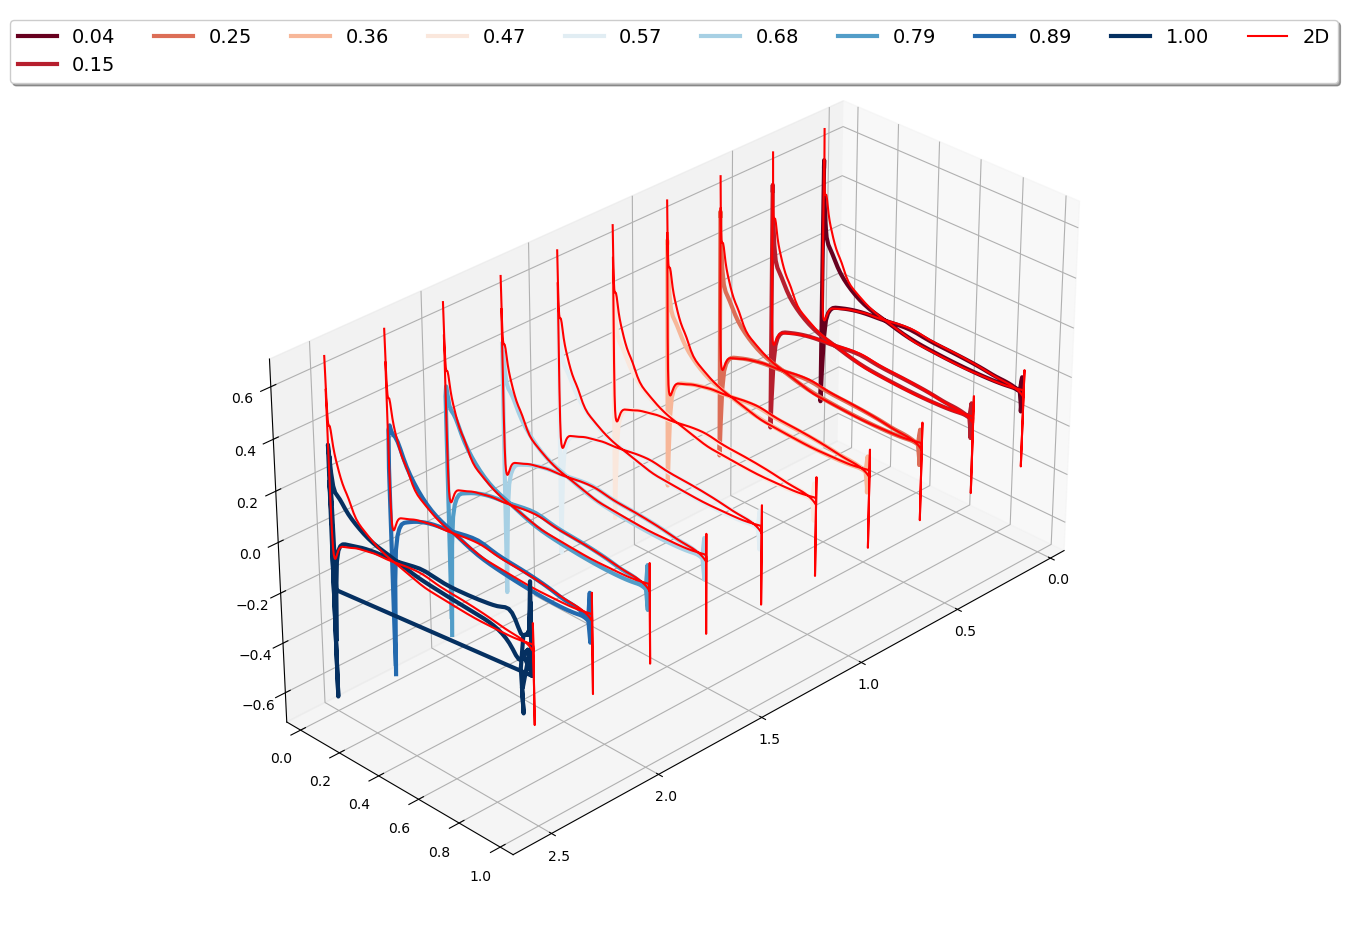

In [42]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')

# Calculate the color for each dataset
cmap = plt.get_cmap('RdBu')
colors = [cmap(i) for i in np.linspace(0, 1, len(data))]

for color, dat, z in zip(colors, data, zcoords):
    x = dat[:,0]
    y = dat[:,1]
    vx = dat[:,3]
    vy = dat[:,4]
    p = dat[:,6]
    
    ax.plot(z*np.ones(x.shape), x, vy/(vy.max()-vy.min()), color=color, label=f'{z/max(zcoords):.2f}', linewidth=3)

    if z==zmax:
        break
    ax.plot(z*np.ones(d2_df['CoordinateX'].values.shape), d2_df['CoordinateX'].values, d2_df['VY'].values/(d2_df['VY'].values.max() - d2_df['VY'].values.min()), color='red')

ax.plot(z*np.ones(d2_df['CoordinateX'].values.shape), d2_df['CoordinateX'].values, d2_df['VY'].values/(d2_df['VY'].values.max() - d2_df['VY'].values.min()), color='red', label='2D')


ax.grid()
ax.set_aspect('equal')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
              ncol=min(len(data), len(data)), fancybox=True, shadow=True, fontsize=14)

# Set the azimuth and elevation angles
ax.view_init(azim=45, elev=30)
plt.savefig('vy.png')
plt.show()

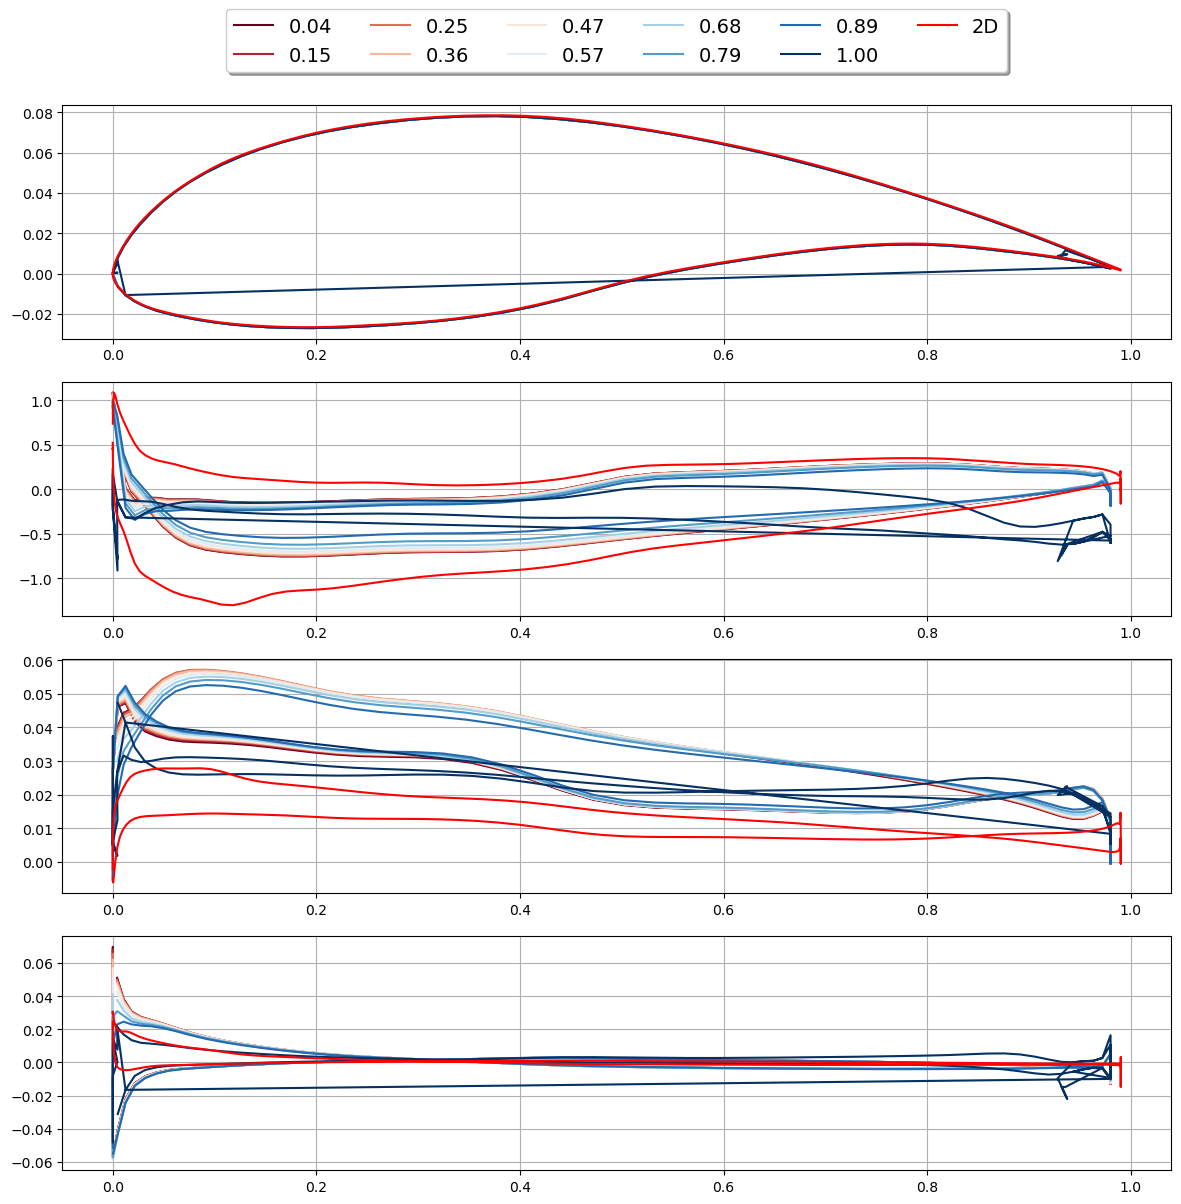

In [44]:
fig, axs = plt.subplots(nrows=4, ncols=1,figsize=(12,12), tight_layout=True)

# Calculate the color for each dataset
cmap = plt.get_cmap('RdBu')
colors = [cmap(i) for i in np.linspace(0, 1, len(data))]

for color, dat, z in zip(colors, data, zcoords):
    x = dat[:,0]
    y = dat[:,1]
    vx = dat[:,3]
    vy = dat[:,4]
    p = dat[:,6]

    axs[0].plot(x,y,color=color, label=f'{z/max(zcoords):.2f}')
    axs[1].plot(x,p,color=color)
    axs[2].plot(x,vx,color=color)
    axs[3].plot(x,vy,color=color)

axs[0].plot(d2_df['CoordinateX'].values, d2_df['CoordinateY'].values, color='red', label='2D')
axs[1].plot(d2_df['CoordinateX'].values, d2_df['CP'], color='red', label='2D')
axs[2].plot(d2_df['CoordinateX'].values, d2_df['VX'], color='red', label='2D')
axs[3].plot(d2_df['CoordinateX'].values, d2_df['VY'], color='red', label='2D')

for ax in axs:
    ax.grid()

axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.45),
              ncol=len(data)//2+1, fancybox=True, shadow=True, fontsize=14)
plt.show()